# RQ1: Impact of LLMs

- [Vanilla](#vanilla)
- [Few-shot learning](#few-shot-learning)
- [RAG](#rag)
- [Baseline](#baseline)
- [Fine-tuning](#fine-tuning)
- [Effectiveness on Large Test Suite](#effectiveness-on-large-test-suite)

In [ ]:
import os
import pandas as pd
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import numpy as np

In [2]:
EXPERIMENT_RESULTS_PATH = "../AutonomicTester/experiment_results"
LABELS = ["similar", "fixed", "buggy"]
FORMAL_LABELS = ["already-tested", "need-test", "error-prone"]
LARGE_TEST_SUITE_PATH = "plotdata/large_test_suite.csv"

In [ ]:
def compute_metrics(y_true: list, y_pred: list):
    precision = precision_score(
        y_true, y_pred, labels=LABELS, average=None, zero_division=0
    )
    recall = recall_score(y_true, y_pred, labels=LABELS, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, labels=LABELS, average=None, zero_division=0)
    not_yet_tested_f1 = f1[1:].mean()
    avg_f1 = f1_score(y_true, y_pred, labels=LABELS, average="macro", zero_division=0)
    print(
        " | ".join(
            [f"{l}(P R F1)" for l in FORMAL_LABELS]
            + ["not-yet-tested F1", "Total Average F1"]
        )
    )
    print(
        " & ".join(
            [
                " & ".join([f"{precision[i]:.2f}", f"{recall[i]:.2f}", f"{f1[i]:.2f}"])
                for i in range(len(LABELS))
            ]
            + [f"{not_yet_tested_f1:.2f}", f"{avg_f1:.2f}"]
        )
    )
    # avg_precision = precision_score(
    #     y_true, y_pred, labels=LABELS, average="macro", zero_division=0
    # )
    # avg_recall = recall_score(
    #     y_true, y_pred, labels=LABELS, average="macro", zero_division=0
    # )
    # print(f"avg_precision: {avg_precision:.2f}, avg_recall: {avg_recall:.2f}")
    f1_scores = {label: f1[i] for i, label in enumerate(FORMAL_LABELS)}
    f1_scores["not-yet-tested"] = not_yet_tested_f1
    f1_scores["total average"] = avg_f1
    return f1_scores


def summarize_metrics(llm_folder: str):
    """
    Summarize metrics about effectiveness for a specific LLM.

    Parameters
    ----------
    llm_folder: str
       folder name of experiments for a specific LLM
    """
    print("Summary Metrics of Experiment at", llm_folder)
    model_experiments_path = os.path.join(EXPERIMENT_RESULTS_PATH, llm_folder)
    classification_df_path = os.path.join(
        model_experiments_path, "scenario_classification.csv"
    )
    y_true = []
    y_pred = []
    if os.path.exists(classification_df_path):
        df_exp = pd.read_csv(classification_df_path)
        y_true = df_exp["target_scenario"].to_list()
        y_pred = df_exp["classified_scenario"].to_list()
    else:
        for experiment in os.listdir(model_experiments_path):
            experiment_path = os.path.join(model_experiments_path, experiment)
            # Skip not directories
            if not os.path.isdir(experiment_path):
                continue
            true_scenario = experiment.split("_")[-1]
            # Read statistics
            df_votes = pd.read_csv(os.path.join(experiment_path, "scenario_votes.csv"))
            df_votes["truth"] = true_scenario
            y_pred += df_votes["scenario"].to_list()
            y_true += df_votes["truth"].to_list()
    return compute_metrics(y_true, y_pred)

## Vanilla

In [4]:
summarize_metrics("vanilla/Llama3 8B")

already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.26 & 0.19 & 0.22 & 0.36 & 0.51 & 0.42 & 0.36 & 0.27 & 0.31 & 0.37 & 0.32
avg_precision: 0.32, avg_recall: 0.33


In [5]:
summarize_metrics("vanilla/Llama3 70B")

already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.18 & 0.29 & 0.22 & 0.34 & 0.28 & 0.31 & 0.28 & 0.19 & 0.23 & 0.27 & 0.25
avg_precision: 0.27, avg_recall: 0.25


In [6]:
summarize_metrics("vanilla/GPT3.5Turbo")

already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.26 & 0.10 & 0.15 & 0.35 & 0.64 & 0.46 & 0.36 & 0.23 & 0.28 & 0.37 & 0.30
avg_precision: 0.33, avg_recall: 0.33


In [7]:
summarize_metrics("vanilla/GPT4Turbo")

already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.17 & 0.20 & 0.18 & 0.34 & 0.56 & 0.42 & 0.31 & 0.07 & 0.11 & 0.26 & 0.24
avg_precision: 0.27, avg_recall: 0.28


In [8]:
summarize_metrics("vanilla/GPT4o")

already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.19 & 0.33 & 0.24 & 0.32 & 0.38 & 0.35 & 0.37 & 0.10 & 0.16 & 0.25 & 0.25
avg_precision: 0.29, avg_recall: 0.27


## Few-shot learning

In [9]:
summarize_metrics("fewshot/GPT4Turbo 3shots")

already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.19 & 0.24 & 0.21 & 0.35 & 0.52 & 0.42 & 0.32 & 0.09 & 0.14 & 0.28 & 0.26
avg_precision: 0.28, avg_recall: 0.28


In [10]:
summarize_metrics("fewshot/GPT4Turbo 6shots")

already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.15 & 0.19 & 0.17 & 0.35 & 0.55 & 0.43 & 0.32 & 0.08 & 0.13 & 0.28 & 0.24
avg_precision: 0.27, avg_recall: 0.27


In [11]:
summarize_metrics("fewshot/GPT4Turbo 9shots")

already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.17 & 0.24 & 0.20 & 0.34 & 0.54 & 0.42 & 0.30 & 0.04 & 0.07 & 0.24 & 0.23
avg_precision: 0.27, avg_recall: 0.27


## RAG

In [12]:
summarize_metrics("rag/Llama3 8B")

already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.23 & 0.28 & 0.26 & 0.43 & 0.51 & 0.47 & 0.53 & 0.37 & 0.44 & 0.45 & 0.39
avg_precision: 0.40, avg_recall: 0.39


In [13]:
summarize_metrics("rag/Llama3 70B")

already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.22 & 0.51 & 0.30 & 0.34 & 0.22 & 0.27 & 0.62 & 0.32 & 0.42 & 0.35 & 0.33
avg_precision: 0.39, avg_recall: 0.35


In [14]:
summarize_metrics("rag/GPT3.5Turbo")

already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.19 & 0.08 & 0.11 & 0.42 & 0.71 & 0.53 & 0.60 & 0.40 & 0.48 & 0.50 & 0.37
avg_precision: 0.40, avg_recall: 0.40


In [15]:
summarize_metrics("rag/GPT4Turbo")

already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.15 & 0.34 & 0.21 & 0.31 & 0.33 & 0.32 & 0.55 & 0.11 & 0.19 & 0.25 & 0.24
avg_precision: 0.34, avg_recall: 0.26


In [16]:
summarize_metrics("rag/DeepseekR1 70B")

already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.18 & 0.29 & 0.22 & 0.29 & 0.24 & 0.26 & 0.52 & 0.45 & 0.48 & 0.37 & 0.32
avg_precision: 0.33, avg_recall: 0.32


## Baseline
Random classifier with equal probability for predicting each scenario.

In [53]:
dummy_clf = DummyClassifier(strategy="uniform")
X = list(range(1975))
y_true = ["buggy"] * 719 + ["fixed"] * 719 + ["similar"] * 537
dummy_clf.fit(X, y_true)
all_y_pred = []
all_y_true = []
for _ in range(10):
    y_pred = dummy_clf.predict(X)
    all_y_pred += y_pred.tolist()
    all_y_true += y_true
compute_metrics(all_y_true, all_y_pred)

already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.27 & 0.33 & 0.30 & 0.35 & 0.33 & 0.34 & 0.37 & 0.33 & 0.35 & 0.34 & 0.33
avg_precision: 0.33, avg_recall: 0.33


## Fine-tuning
- E-Test
- E-Test RAG

In [17]:
summarize_metrics("finetuning/FineTunedGPT3.5Turbo")

already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.66 & 0.94 & 0.78 & 0.47 & 0.24 & 0.31 & 0.48 & 0.57 & 0.53 & 0.42 & 0.54
avg_precision: 0.54, avg_recall: 0.58


In [18]:
summarize_metrics("rag/FineTunedGPT3.5Turbo")

already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.47 & 0.41 & 0.44 & 0.51 & 0.61 & 0.56 & 0.52 & 0.46 & 0.49 & 0.52 & 0.50
avg_precision: 0.50, avg_recall: 0.50


### Temperature

In [107]:
def analyze_temperature_experiments() -> dict:
    temperature_experiments = {}
    target_path = os.path.join(EXPERIMENT_RESULTS_PATH, "temperature")
    for model_folder in os.listdir(target_path):
        model_path = os.path.join(target_path, model_folder)
        if not os.path.isdir(model_path):
            continue
        temperature_experiments[model_folder] = {}
        for repetition_folder in os.listdir(model_path):
            repetition_path = os.path.join(model_path, repetition_folder)
            if not os.path.isdir(repetition_path):
                continue
            temperature_experiments[model_folder][repetition_folder] = {}
            for temperature_folder in os.listdir(repetition_path):
                temperature_path = os.path.join(repetition_path, temperature_folder)
                if not os.path.isdir(temperature_path):
                    continue
                # read predictions and ground truths
                y_true = []
                y_pred = []
                if model_folder == "E-Test":
                    for experiment in os.listdir(temperature_path):
                        experiment_path = os.path.join(temperature_path, experiment)
                        # Skip not directories
                        if not os.path.isdir(experiment_path):
                            continue
                        df_exp = pd.read_csv(
                            os.path.join(experiment_path, "scenario_votes.csv")
                        )
                        y_true += df_exp["truth"].to_list()
                        y_pred += df_exp["scenario"].to_list()
                    if y_true == [] and y_pred == []:
                        df_exp = pd.read_csv(
                            os.path.join(temperature_path, "scenario_votes.csv")
                        )
                        y_true += df_exp["truth"].to_list()
                        y_pred += df_exp["scenario"].to_list()
                else:
                    df_exp = pd.read_csv(
                        os.path.join(temperature_path, "scenario_votes.csv")
                    )
                    y_true += df_exp["truth"].to_list()
                    y_pred += df_exp["scenario"].to_list()
                # compute metrics
                print(model_folder, repetition_folder, temperature_folder)
                temperature_experiments[model_folder][repetition_folder][
                    temperature_folder
                ] = compute_metrics(y_true, y_pred)
    return temperature_experiments

In [108]:
temperature_experiments = analyze_temperature_experiments()

Deepseek R1 70B repetition1 t1.5
already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.26 & 0.31 & 0.28 & 0.36 & 0.20 & 0.26 & 0.38 & 0.50 & 0.43 & 0.34 & 0.32
Deepseek R1 70B repetition1 t2
already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.27 & 0.32 & 0.29 & 0.37 & 0.21 & 0.27 & 0.40 & 0.52 & 0.45 & 0.36 & 0.33
Deepseek R1 70B repetition1 t0.75
already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.24 & 0.27 & 0.25 & 0.31 & 0.16 & 0.22 & 0.39 & 0.54 & 0.46 & 0.34 & 0.31
Deepseek R1 70B repetition1 t0
already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.25 & 0.30 & 0.28 & 0.31 & 0.14 & 0.20 & 0.38 & 0.53 & 0.44 & 0.32 & 0.31
E-Test repetition1 t1.5
already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.66 & 0.94 & 0.78 & 0.46 &

In [ ]:
def draw_f1_with_temperature(temperature_experiments: dict):
    plt.rcParams.update({"text.usetex": True, "font.family": "Times New Roman"})
    cmap = plt.get_cmap("tab10")
    colors = [cmap(i) for i in range(len(temperature_experiments))]
    fig, ax = plt.subplots(figsize=(10, 6))
    for index, (model, repetitions) in enumerate(temperature_experiments.items()):
        if model not in ["Deepseek R1 14B", "Deepseek R1 1.5B", "E-Test"]:
            continue
        # aggregate f1 scores
        min_f1_scores = []
        avg_f1_scores = []
        max_f1_scores = []
        for temp in ["t0", "t0.75", "t1.5", "t2"]:
            f1_scores = [
                repetitions[rep_index][temp]["total average"]
                for rep_index in ["repetition1", "repetition2", "repetition3"]
            ]
            min_f1_scores.append(min(f1_scores))
            avg_f1_scores.append(np.mean(f1_scores))
            max_f1_scores.append(max(f1_scores))
        # plot
        x = [0, 0.75, 1.5, 2]  # temperatures of LLMs
        ax.plot(x, avg_f1_scores, marker="o", color=colors[index], label=model)
        if model == "E-Test":
            ax.fill_between(
                x, min_f1_scores, max_f1_scores, color=colors[index], alpha=0.3
            )
        ax.set_ylim(0, 1)
        ax.set_xticks(x)
        ax.tick_params(axis="both", labelsize=14)
        ax.set_xlabel("Temperature", fontsize=16)
        ax.set_ylabel("F1-score", fontsize=16)
        ax.legend(fontsize=16)
        fig.savefig("images/inverse_scaling_by_temperature.pdf", bbox_inches="tight")

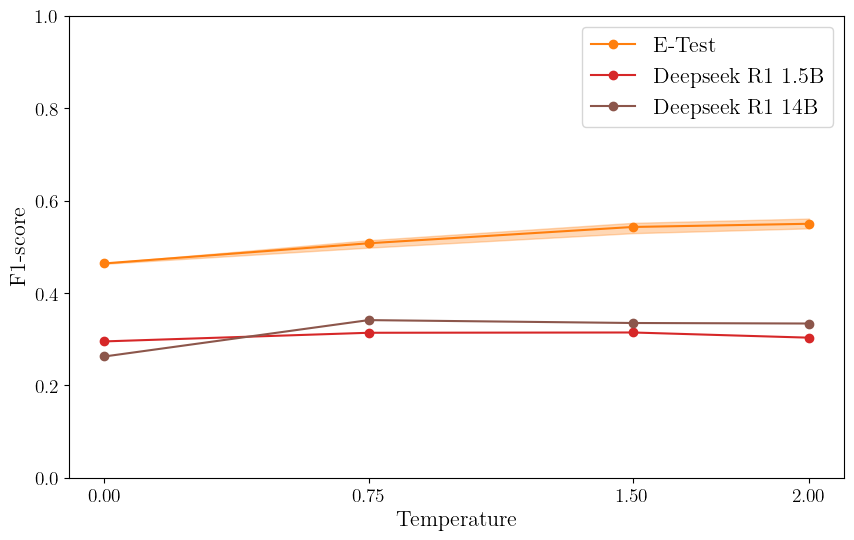

In [137]:
draw_f1_with_temperature(temperature_experiments)

In [ ]:
df_temperatures = pd.DataFrame(
    [
        f1_scores_t0,
        f1_scores_t025,
        f1_scores_t05,
        f1_scores_t075,
        f1_scores_t1,
        f1_scores_t125,
        f1_scores_t15,
        f1_scores_t175,
        f1_scores_t2,
    ],
    index=[0.25 * i for i in range(9)],
)

[[0.12156863 0.46666667 0.70588235 1.        ]
 [0.59607843 0.8745098  0.54117647 1.        ]
 [0.54901961 0.3372549  0.29411765 1.        ]
 [0.78039216 0.78039216 0.78039216 1.        ]
 [0.61960784 0.85490196 0.89803922 1.        ]]


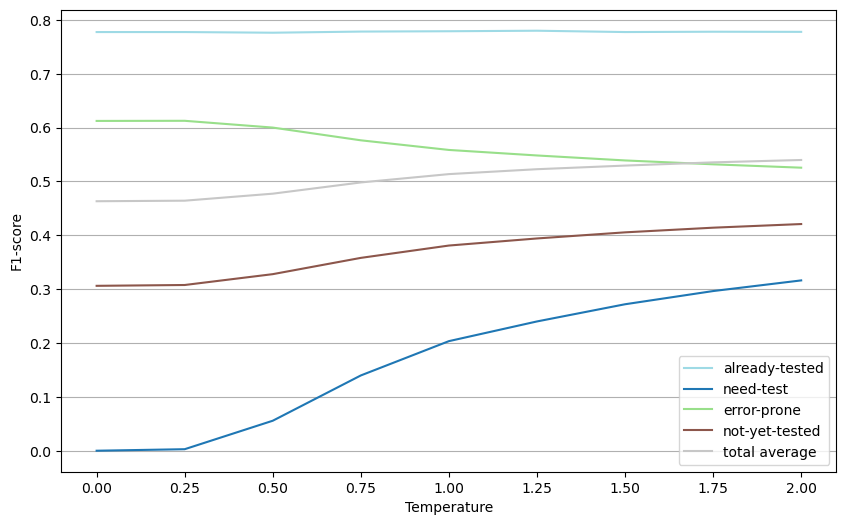

In [36]:
plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(df_temperatures.columns)))
# TODO use a beautiful color palette
for i, col in enumerate(df_temperatures.columns):
    color = colors[i - 1]
    plt.plot(df_temperatures.index, df_temperatures[col], color=color, label=col)
plt.xlabel("Temperature")
plt.ylabel("F1-score")
plt.grid(axis="y")
plt.legend()

## Inverse Scaling

In [37]:
summarize_metrics("temperature/Deepseek R1 1.5B/repetition1")

Summary Metrics of Experiment at temperature/Deepseek R1 1.5B/repetition1


FileNotFoundError: [Errno 2] No such file or directory: '../AutonomicTester/experiment_results/temperature/Deepseek R1 1.5B/repetition1/20250701_100359_Deepseek R1 1.5B_Defects_all/scenario_votes.csv'

## Effectiveness on Large Test Suite

In [54]:
TEST_SUITE_STATS_PATH = "plotdata/test_suite_stats.jsonl"
FILTERED_SCENARIOS_PATH = "plotdata/filtered_scenarios.csv"

In [55]:
df_filtered_scenarios = pd.read_csv(FILTERED_SCENARIOS_PATH)
df_test_suite_stats = pd.read_json(TEST_SUITE_STATS_PATH, lines=True)
df_test_suite_stats["bug"] = df_test_suite_stats["bug"].astype(int)

In [56]:
index_columns = ["project", "bug", "scenario_index"]
df_ts = df_filtered_scenarios.set_index(index_columns).join(
    df_test_suite_stats.set_index(index_columns), how="left"
)

In [57]:
df_ts

buggy_class  \
project bug scenario_index                                                      
Chart   1   0               org.jfree.chart.renderer.category.AbstractCate...   
        2   1                         org.jfree.data.general.DatasetUtilities   
        3   0                                  org.jfree.data.time.TimeSeries   
        4   13                                    org.jfree.chart.plot.XYPlot   
        5   0                                      org.jfree.data.xy.XYSeries   
...                                                                       ...   
Time    23  0                                      org.joda.time.DateTimeZone   
        24  6                       org.joda.time.format.DateTimeParserBucket   
        25  0                                      org.joda.time.DateTimeZone   
        26  21                           org.joda.time.chrono.ZonedChronology   
        27  0                     org.joda.time.format.PeriodFormatterBuilder   

                                                                 buggy_method  \
project bug scenario_index                                                      
Chart   1   0               org.jfree.chart.renderer.category.AbstractCate...   
        2   1               org.jfree.data.general.DatasetUtilities.iterat...   
        3   0               org.jfree.data.time.TimeSeries.createCopy(int,...   
        4   13              org.jfree.chart.plot.XYPlot.getDataRange(org.j...   
        5   0               org.jfree.data.xy.XYSeries.addOrUpdate(java.la...   
...                                                                       ...   
Time    23  0               org.joda.time.DateTimeZone.getConvertedId(java...   
        24  6               org.joda.time.format.DateTimeParserBucket.comp...   
        25  0               org.joda.time.DateTimeZone.getOffsetFromLocal(...   
        26  21              org.joda.time.chrono.ZonedChronology.ZonedDate...   
        27  0               org.joda.time.format.PeriodFormatterBuilder.to...   

                                                              test_suite_name  \
project bug scenario_index                                                      
Chart   1   0               org.jfree.chart.renderer.category.junit.Abstra...   
        2   1               org.jfree.data.general.junit.DatasetUtilitiesT...   
        3   0                       org.jfree.data.time.junit.TimeSeriesTests   
        4   13                         org.jfree.chart.junit.XYAreaChartTests   
        5   0                           org.jfree.data.xy.junit.XYSeriesTests   
...                                                                       ...   
Time    23  0                                  org.joda.time.TestDateTimeZone   
        24  6                      org.joda.time.format.TestDateTimeFormatter   
        25  0                           org.joda.time.TestDateTimeZoneCutover   
        26  21                          org.joda.time.TestDateTimeZoneCutover   
        27  0                 org.joda.time.format.TestPeriodFormatterBuilder   

                            test_case_count  num_chars  num_gpt_tokens  \
project bug scenario_index                                               
Chart   1   0                             9      10287            2181   
        2   1                            52      36773            9669   
        3   0                            36      28126            7136   
        4   13                            0       1743             400   
        5   0                            20      11121            3185   
...                                     ...        ...             ...   
Time    23  0                            41      33700            7128   
        24  6                            50      33424            9832   
        25  0                           111      55088           18392   
        26  21                          100      48136           16416   
        27  0   

In [58]:
count_exceed_context_limit = len(df_ts[df_ts["num_gpt_tokens"] > 16385])
percentage_exceed_context_limit = 100 * count_exceed_context_limit / len(df_ts)
print(
    f"{percentage_exceed_context_limit:.2f}% scenarios include test suite size longer than 8K tokens, which exceeds the limit when building raw prompts"
)

6.59% scenarios include test suite size longer than 8K tokens, which exceeds the limit when building raw prompts


In [64]:
df_rag = df_ts[df_ts["num_gpt_tokens"] > 16385]

In [65]:
df_rag.index.to_frame().to_csv("plotdata/large_test_suite.csv", index=False)

In [72]:
def compare_rag_improvement_over_large_test_suite(model: str):
    df_rag_exp = pd.read_csv(
        os.path.join(
            EXPERIMENT_RESULTS_PATH, "rag", model, "scenario_classification.csv"
        )
    )
    df_large_test_suite = pd.read_csv(LARGE_TEST_SUITE_PATH)[["project", "bug"]]
    # Read dataframe of experiment without RAG
    model_experiments_path = os.path.join(EXPERIMENT_RESULTS_PATH, "vanilla", model)
    exp_without_rag = []
    for experiment in os.listdir(model_experiments_path):
        experiment_path = os.path.join(
            model_experiments_path, experiment, "scenario_votes.csv"
        )
        true_scenario = experiment.split("_")[-1]
        df_exp = pd.read_csv(experiment_path)
        df_exp["target_scenario"] = true_scenario
        exp_without_rag.append(df_exp)
    df_exp_without_rag = pd.concat(exp_without_rag)
    df_exp_without_rag = df_exp_without_rag.rename(
        columns={"bug id": "bug", "scenario": "classified_scenario"}
    )[["project", "bug", "classified_scenario", "target_scenario"]]
    # Read dataframe of experiment with RAG
    df_exp_with_rag = df_rag_exp[
        ["project", "bug", "classified_scenario", "target_scenario"]
    ]
    # Filtered dataframe on large test suite
    df_exp_with_rag_large_ts = (
        df_large_test_suite.set_index(["project", "bug"])
        .join(df_exp_with_rag.set_index(["project", "bug"]))
        .reset_index()
    )
    df_exp_without_rag_large_ts = (
        df_large_test_suite.set_index(["project", "bug"])
        .join(df_exp_without_rag.set_index(["project", "bug"]))
        .reset_index()
    )
    print("With RAG")
    compute_metrics(
        df_exp_with_rag_large_ts["target_scenario"].tolist(),
        df_exp_with_rag_large_ts["classified_scenario"].tolist(),
    )
    print("\nWithout RAG")
    compute_metrics(
        df_exp_without_rag_large_ts["target_scenario"].tolist(),
        df_exp_without_rag_large_ts["classified_scenario"].tolist(),
    )

In [73]:
compare_rag_improvement_over_large_test_suite("Llama3 8B")

With RAG
already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.35 & 0.52 & 0.42 & 0.55 & 0.52 & 0.54 & 0.64 & 0.50 & 0.56 & 0.55 & 0.50
avg_precision: 0.51, avg_recall: 0.51

Without RAG
already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.33 & 0.17 & 0.23 & 0.36 & 0.36 & 0.36 & 0.38 & 0.53 & 0.44 & 0.40 & 0.34
avg_precision: 0.36, avg_recall: 0.35


In [74]:
compare_rag_improvement_over_large_test_suite("Llama3 70B")

With RAG
already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.23 & 0.55 & 0.32 & 0.33 & 0.16 & 0.22 & 0.62 & 0.42 & 0.50 & 0.36 & 0.35
avg_precision: 0.39, avg_recall: 0.38

Without RAG
already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.14 & 0.25 & 0.18 & 0.33 & 0.23 & 0.27 & 0.22 & 0.13 & 0.17 & 0.22 & 0.21
avg_precision: 0.23, avg_recall: 0.20


In [75]:
compare_rag_improvement_over_large_test_suite("GPT3.5Turbo")

With RAG
already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.40 & 0.07 & 0.12 & 0.49 & 0.68 & 0.57 & 0.67 & 0.72 & 0.69 & 0.63 & 0.46
avg_precision: 0.52, avg_recall: 0.49

Without RAG
already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.18 & 0.06 & 0.09 & 0.31 & 0.61 & 0.41 & 0.36 & 0.20 & 0.25 & 0.33 & 0.25
avg_precision: 0.29, avg_recall: 0.29


In [76]:
compare_rag_improvement_over_large_test_suite("GPT4Turbo")

With RAG
already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.18 & 0.55 & 0.27 & 0.38 & 0.24 & 0.29 & 0.67 & 0.12 & 0.20 & 0.25 & 0.26
avg_precision: 0.41, avg_recall: 0.30

Without RAG
already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.03 & 0.03 & 0.03 & 0.31 & 0.57 & 0.40 & 0.00 & 0.00 & 0.00 & 0.20 & 0.14
avg_precision: 0.11, avg_recall: 0.20


In [83]:
def plot_bars_large_test_suite():
    fontsize_paper = 18
    # Settings for plots
    plt.rcParams.update({"text.usetex": True, "font.family": "Times New Roman"})
    DARK_GREEN = "#1e8449"
    DARK_BLUE = "#2874a6"
    labels = ["Llama3 8B", "Llama3 70B", "GPT-3.5 Turbo", "GPT-4 Turbo"]
    models = ["Llama3 8B", "Llama3 70B", "GPT3.5Turbo", "GPT4Turbo"]
    values_without_rag = [0.34, 0.21, 0.25, 0.14]
    values_with_rag = [0.50, 0.35, 0.46, 0.26]
    width = 0.3
    fig, ax = plt.subplots(tight_layout=True)
    x = np.arange(len(labels))  # X locations for groups
    bars1 = ax.bar(
        x - width / 2,
        values_without_rag,
        width,
        label="prompt without RAG",
        color=DARK_GREEN,
    )
    bars2 = ax.bar(
        x + width / 2,
        values_with_rag,
        width,
        label="prompt with RAG",
        color=DARK_BLUE,
    )
    for i, v in enumerate(values_without_rag):
        if v != 0:
            ax.text(
                x[i] - width / 2,
                v,
                f"{v:.2f}%",
                ha="center",
                va="bottom",
                fontsize=fontsize_paper,
            )
    for i, v in enumerate(values_with_rag):
        if v != 0:
            ax.text(
                x[i] + width / 2,
                v,
                f"{v:.2f}%",
                ha="center",
                va="bottom",
                fontsize=fontsize_paper,
            )

    # Labels and title
    ax.set_ylabel("Total Avg. F1", fontsize=fontsize_paper)
    ax.set_xticks(x)  # Set ticks at group positions
    ax.set_xticklabels(labels, rotation=35, fontsize=fontsize_paper)  # Set tick labels
    ax.legend(fontsize=fontsize_paper)
    ax.tick_params(axis="y", labelsize=fontsize_paper)
    ax.set_ylim(top=0.8)
    fig.savefig("images/large_test_suite.pdf", bbox_inches="tight")

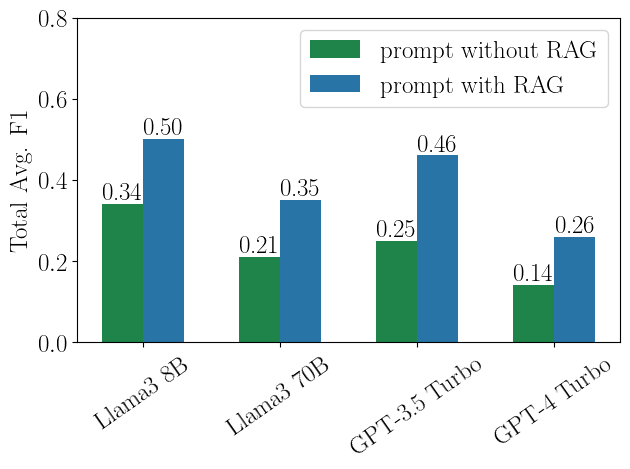

In [84]:
plot_bars_large_test_suite()